In [3]:
!pip -q install "nbconvert>=7.0,<8.0" nbformat

# ⬇️ (Optional) Mount Google Drive if your .ipynb files live there
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os, pathlib, subprocess

Mounted at /content/drive


In [6]:
root_folder = "/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code"   # ← change to your folder
input_files = [str(p) for p in pathlib.Path(root_folder).rglob("*.ipynb")]
input_files

['/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/conversion.ipynb',
 '/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 1/Notebooks/Parcours_Makers_Module_1_Prompt_engineering_avance_Cours_1.ipynb',
 '/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 1/Notebooks/Parcours_Makers_Module_1_Prompt_engineering_avance_Cours_2.ipynb',
 '/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 1/Notebooks/Parcours_Makers_Module_1_Prompt_engineering_avance_Cours_3.ipynb',
 '/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 2/Notebooks/Parcours_Makers_Module_1_RAG_Cours_1.ipynb',
 '/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 2/Notebooks/Parcours_Makers_Module_1_RAG_Cours_2.ipynb',
 '/content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 2/Notebooks/Parcours_Makers_Module_

In [7]:
import os, pathlib, subprocess, nbformat

# Temp dir for cleaned notebooks
tmp_dir = pathlib.Path("/content/nbclean")
tmp_dir.mkdir(parents=True, exist_ok=True)

def strip_widgets(nb):
    """Remove widget state/outputs that trigger KeyError: 'state' in nbconvert."""
    changed = False
    # Remove top-level widget metadata if present
    for key in ("widgets", "widget_state"):
        if key in nb.metadata:
            nb.metadata.pop(key, None)
            changed = True

    for cell in nb.cells:
        # Some notebooks stash widget state under cell metadata
        for key in ("widgets", "widget_state"):
            if hasattr(cell, "metadata") and key in cell.metadata:
                cell.metadata.pop(key, None)
                changed = True

        # Remove outputs that are widget views
        if getattr(cell, "outputs", None):
            new_outputs = []
            for out in cell.outputs:
                # If output has MIME data, drop widget-specific MIME types
                data = getattr(out, "data", None)
                if isinstance(data, dict):
                    if "application/vnd.jupyter.widget-view+json" in data:
                        data.pop("application/vnd.jupyter.widget-view+json", None)
                        changed = True
                    # If nothing left, skip this output entirely
                    if not data:
                        continue
                new_outputs.append(out)
            if len(new_outputs) != len(cell.outputs):
                changed = True
            cell.outputs = new_outputs
    return changed

failures = []

for nb_path in input_files:
    p = pathlib.Path(nb_path)

    # Create sibling HTML directory next to "Notebooks"
    html_dir = p.parent.parent / "HTML"
    os.makedirs(html_dir, exist_ok=True)

    # Clean notebook → temp file
    nb = nbformat.read(nb_path, as_version=4)
    changed = strip_widgets(nb)
    cleaned = tmp_dir / f"{p.stem}_clean.ipynb"
    nbformat.write(nb, cleaned)

    out_name = p.stem  # keep base name
    print(f"→ Converting:\n   {nb_path}\n   to: {html_dir}/{out_name}.html (widgets stripped: {changed})")
    try:
        subprocess.run(
            [
                "jupyter", "nbconvert",
                "--to", "html",
                "--template", "lab",                 # look & feel JupyterLab (code inclus)
                "--HTMLExporter.embed_images=True",  # inline des images
                "--HTMLExporter.sanitize_html=False",
                "--output-dir", str(html_dir),
                "--output", out_name,
                str(cleaned),
            ],
            check=True,
            capture_output=True,
            text=True,
        )
    except subprocess.CalledProcessError as e:
        print(f"   ❌ Failed: {p.name}\n   {e.stderr.splitlines()[-1] if e.stderr else ''}")
        failures.append(nb_path)

print("\n✅ Done.")
if failures:
    print("Some files failed to convert:")
    for f in failures:
        print(" -", f)

→ Converting:
   /content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/conversion.ipynb
   to: /content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/HTML/conversion.html (widgets stripped: False)
→ Converting:
   /content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 1/Notebooks/Parcours_Makers_Module_1_Prompt_engineering_avance_Cours_1.ipynb
   to: /content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 1/HTML/Parcours_Makers_Module_1_Prompt_engineering_avance_Cours_1.html (widgets stripped: False)
→ Converting:
   /content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 1/Notebooks/Parcours_Makers_Module_1_Prompt_engineering_avance_Cours_2.ipynb
   to: /content/drive/MyDrive/6. Data Impulse/3. Missions/Cleo/Code/Parcours Makers/Module 1/HTML/Parcours_Makers_Module_1_Prompt_engineering_avance_Cours_2.html (widgets stripped: False)
→ Converting:
   /content/drive/MyDrive/6.

Copy this HTML tag:



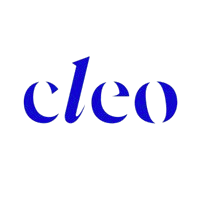


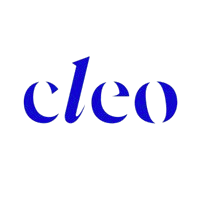

In [ ]:
# === Inline image as a data: URI (no external requests) ======================
# Fill ONE of these:
local_image_path = None
drive_link = "https://drive.google.com/file/d/1xZPGJpfeCyY2e_E0OsT0rlh4uZXgsN6p/view?usp=drive_link"

# ---------------------------------------------------------------------------
import base64, mimetypes, pathlib, re, urllib.request, os

def download_from_drive(url: str, out_path: str) -> str:
    """Download a public Drive file (by link) to out_path and return the path."""
    m = re.search(r'(?:id=|/d/)([A-Za-z0-9_-]{10,})', url)
    if not m:
        raise ValueError("Could not find a Google Drive file ID in the URL.")
    file_id = m.group(1)
    dl = f"https://drive.google.com/uc?export=download&id={file_id}"
    urllib.request.urlretrieve(dl, out_path)
    return out_path

# Decide the source path
src_path = None
if local_image_path and os.path.exists(local_image_path):
    src_path = local_image_path
elif drive_link:
    # Pick an extension if you know it; otherwise we'll try to guess later.
    tmp_path = "/content/tmp_image"
    src_path = download_from_drive(drive_link, tmp_path)
else:
    raise ValueError("Set either local_image_path or drive_link.")

# Guess MIME type (defaults to PNG if unknown)
mime, _ = mimetypes.guess_type(src_path)
mime = mime or "image/png"

data = pathlib.Path(src_path).read_bytes()
b64 = base64.b64encode(data).decode("ascii")
data_uri = f"data:{mime};base64,{b64}"

# Build your final tag (adjust width/style as you like)
img_tag = f'<img src="{data_uri}" width="80" style="float:left">'
print("Copy this HTML tag:\n")
print(img_tag)

# Optional: also show a quick preview in the notebook
from IPython.display import HTML, display
display(HTML(f"<div>{img_tag}</div>"))
